# HW 04 - Applied ML

In [80]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from numpy import unravel_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score

from sklearn_pandas import DataFrameMapper

In [81]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv', index_col='playerShort')
df.sample(10)

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,,
jonathan-viera,Jonathan Viera,Valencia CF,Spain,21.10.1989,171.0,65.0,Right Winger,1,0,0,...,0.50,2290,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091
abdoul-camara,Abdoul Camara,FC Sochaux,France,20.02.1990,177.0,70.0,Left Winger,8,1,1,...,NaN,126,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
francois-marque,François Marque,SC Bastia,France,31.07.1983,187.0,85.0,Center Back,2,1,0,...,NaN,2796,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,1,...,1.00,2881,57,AUT,0.337539,1319.0,0.000331,0.394139,1365.0,0.001717
anthony-reveillere,Anthony Réveillère,Olympique Lyon,France,10.11.1979,180.0,77.0,Right Fullback,2,1,0,...,0.25,737,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091
clemens-fritz,Clemens Fritz,Werder Bremen,Germany,07.12.1980,183.0,81.0,Right Fullback,1,1,0,...,0.25,1036,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
clint-dempsey,Clint Dempsey,Tottenham Hotspur,England,09.03.1983,185.0,77.0,Attacking Midfielder,1,0,0,...,0.25,1270,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
bocoundji-ca,Bocoundji Cá,Stade Reims,France,28.12.1986,172.0,69.0,Defensive Midfielder,3,1,1,...,0.75,2414,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
aranzubia,Aranzubía,Deportivo La Coruña,Spain,18.09.1979,184.0,80.0,Goalkeeper,1,1,0,...,0.00,2345,101,CZE,0.411976,595.0,0.000712,0.683946,598.0,0.003489


# 1. RandomForestClassifier

The data we have contains player-referee dyads, which doesn't make it good training data, since many players appear several times in the dataset.

This would make the classifier overfit very easily if the model takes into account some fields (e.g. club, weight, height...) by recognising players.

Therefore, we will aggregate the data, grouped by players.

In [82]:
df.isnull().sum()

player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

In [83]:
len(df.dropna())/len(df)

0.790649738406333

In [84]:
# We loose around 20% of dyads, essentially missing ratings which are necessary for training
df = df.dropna()

In [85]:
# Create a "rating" column (8 possible values, from )
df['rating'] = df.rater1 + df.rater2

# Group dataframe by player and aggregate data
feature_agg_function = {
    'height': np.mean,
    'weight': np.mean,
    'victories': np.sum,
    'ties': np.sum,
    'defeats': np.sum,
    'goals': np.sum,
    'yellowCards': np.sum,
    'yellowReds': np.sum,
    'redCards': np.sum,
    'rating': np.mean,
    'meanIAT': np.mean,
    'nIAT': np.mean,
    'seIAT': lambda x: np.sqrt(np.average(np.square(x))),
    'meanExp': np.mean,
    'nExp': np.mean,
    'seExp': lambda x: np.sqrt(np.average(np.square(x))),
}
agg_df = df.reset_index().groupby('playerShort').agg(feature_agg_function)
agg_df.sample(10)

,nExp,yellowReds,ties,goals,seExp,rating,yellowCards,height,victories,meanExp,defeats,weight,redCards,nIAT,seIAT,meanIAT
playerShort,,,,,,,,,,,,,,,,
alex-nimely-tchuimeni,40840.433333,0,15,2,0.000917,1.75,3,180.0,6,0.378323,13,72.0,0,38990.633333,0.000199,0.332852
luis-suarez_5,11211.454545,0,87,234,0.015981,0.25,84,182.0,209,0.518672,101,81.0,2,10725.628099,0.003141,0.352014
marc-valiente,2041.400000,1,52,4,0.012032,0.50,28,184.0,54,0.592456,59,71.0,1,1925.300000,0.001589,0.368484
lars-bender,29982.420455,1,65,26,0.002974,0.00,32,184.0,128,0.434213,84,77.0,0,29126.625000,0.000589,0.345762
jorge-molina_2,1798.102041,0,38,81,0.002118,0.50,16,188.0,71,0.619386,77,87.0,2,1693.795918,0.000418,0.371562
parejo_2,13416.477778,1,54,23,0.004157,0.75,52,180.0,105,0.481483,78,74.0,0,12804.411111,0.000818,0.348492
vedad-ibisevic,48680.320000,0,65,127,0.008763,0.50,47,188.0,125,0.471185,122,80.0,4,47298.790000,0.001340,0.350569
emmanuel-adebayor,12554.678832,1,116,170,0.049711,2.00,43,190.0,234,0.340863,100,75.0,5,11989.058394,0.009874,0.323734
clint-dempsey,156344.095652,0,94,117,0.024229,0.25,32,185.0,169,0.452416,134,77.0,0,151952.173913,0.003579,0.342732


In [86]:
X = np.asanyarray(agg_df[[column for column in agg_df.columns if column != 'rating']])
y = np.asarray(agg_df['rating'] * 4, dtype="int")

In [87]:
#Cross Validation function for testing different parameter combinations
def RandomForestClassifier_CrossValidation(n_estimators_max, n_features_max, max_depth, folds):

    max_k_scores = np.zeros(shape=(n_estimators_max, n_features_max))
    max_k = np.zeros(shape=(n_estimators_max, n_features_max))

    n_estimators_range = range(1,n_estimators_max+1)
    max_features_range = range(1,n_features_max+1)
    max_depth_range = range(1,max_depth+1)


    #loop over number of estimators
    for i in n_estimators_range:
        print("n_estimators = {}".format(i))
        #loop over max number of features
        for j in max_features_range:
            #loop over max depth
            k_scores = []
            for k in max_depth_range:
                #print(k)
                rfc = RandomForestClassifier(
                    n_estimators=i,
                    criterion='gini',  # or 'entropy' ?
                    max_features=j,
                    max_depth=k,
                )
                scores = np.mean(cross_val_score(rfc, X, y, cv = folds))
                k_scores.append(scores.mean())

            max_k_scores[i-1][j-1]=np.max(k_scores)
            max_k[i-1][j-1]=np.argmax(k_scores)+1

            
    #Find coordinates of max score and print
    x_max, y_max = unravel_index(np.argmax(max_k_scores), max_k_scores.shape)
    print(max_k_scores)
    print(max_k)
    print("max score : {}, best n_estimators : {}, best max_features : {}, best max_depth : {}, number of folds : {}"
          .format(max_k_scores[x_max][y_max], x_max+1, y_max+1, max_k[x_max][y_max], folds))
    
    best_n_estimators, best_max_features, best_max_depth = x_max+1, y_max+1, max_k[x_max][y_max]
    
    #Plotting
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X_plot = np.arange(0, n_features_max, 1)
    Y_plot = np.arange(0, n_estimators_max, 1)

    Z_plot = max_k_scores
    X_plot, Y_plot = np.meshgrid(X_plot, Y_plot)

    surf = ax.plot_surface(X_plot, Y_plot, Z_plot, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('max_features')
    ax.set_zlabel('score')


    plt.show()
    
    return best_n_estimators, best_max_features, best_max_depth, max_k_scores

n_estimators = 1
n_estimators = 2
n_estimators = 5
n_estimators = 10
n_estimators = 20
n_estimators = 50
n_estimators = 100
[[ 0.31311451  0.32402     0.32138326  0.30739514  0.31573969  0.32259932
   0.31552729  0.32507117  0.32678098  0.32640293  0.31686717  0.32291399
   0.32202076  0.32095946  0.3206776 ]
 [ 0.319902    0.33124984  0.32898914  0.32850683  0.32572388  0.32212677
   0.33894232  0.32775392  0.33523127  0.33625458  0.33658865  0.33496364
   0.32735138  0.32356552  0.31871432]
 [ 0.33001332  0.34029318  0.33636586  0.33426607  0.3299763   0.33580011
   0.3304225   0.33475389  0.33069882  0.32687946  0.33837401  0.32756592
   0.33403598  0.33957488  0.33116412]
 [ 0.32490329  0.33420268  0.3398469   0.34462596  0.33101803  0.33387463
   0.33052549  0.33469877  0.33756235  0.33963142  0.33880563  0.3368277
   0.3355302   0.33591673  0.34164804]
 [ 0.33472734  0.33717826  0.34090446  0.3392235   0.33885968  0.33982632
   0.34331376  0.33905446  0.3397947   0.33965559  0.33

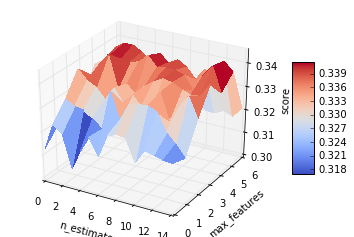

In [61]:
#Run cross validation to find optimal parameters for RFC
best_n_estimators, best_max_features, best_max_depth, max_scores = RandomForestClassifier_CrossValidation([1, 2, 5, 10, 20, 50, 100], len(X[0]), 15, 15)

3D array 

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [120]:
# The best value is for 50 n_estimators
rfc = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',  # or 'entropy' ?
    max_features=best_max_features,
    max_depth=best_max_depth,
)

In [121]:
rfc.fit(X_train,
        y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6.0, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [122]:
y_pred = rfc.predict(X_test)
y_compare = rfc.predict(X_train)
print(sklearn.metrics.accuracy_score(y_test, y_pred), sklearn.metrics.accuracy_score(y_train, y_compare))

0.346478873239 0.531015037594


In [70]:
[x for x in zip(agg_df.columns, rfc.feature_importances_)]

[('nExp', 0.091269528421465684),
 ('yellowReds', 0.016777680762849828),
 ('ties', 0.07152799493753205),
 ('goals', 0.043003428395101254),
 ('seExp', 0.093193226061179898),
 ('rating', 0.059739261133378137),
 ('yellowCards', 0.06399882459370089),
 ('height', 0.061240126503738876),
 ('victories', 0.075153198987315761),
 ('meanExp', 0.072015420806756048),
 ('defeats', 0.063103796636729395),
 ('weight', 0.025293771549276811),
 ('redCards', 0.083779160403480615),
 ('nIAT', 0.092490631567211101),
 ('seIAT', 0.087413949240283714)]

In [30]:
print(np.argmax(rfc.feature_importances_))

6
